In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [8]:
# setup the inspector
from sqlalchemy import inspect
inspector = inspect(engine)

In [9]:
# Print column names for station table and display the first 5 rows
columns_station = inspector.get_columns('station')
for column in columns_station:
    print(column["name"], column["type"])
engine.execute('SELECT * FROM station LIMIT 100').fetchall()

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [10]:
# Print column names for measurment table and display the first 5 rows
columns_measurement = inspector.get_columns('measurement')
for column in columns_measurement:
    print(column["name"], column["type"])
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

**The above measurement table has a column (prcp) for the precipitation for each day.**  It would appear that tobs is the temperature, presumably recorded at the same time each day.  But, the literature describes TOBs as the time of observation error, which is a measure of the bias introduced by making the measurement at a time that is different than the prescribed time (e.g. made in evening when prescribed for morning). 

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [13]:
import datetime as dt

# the following import is needed to support strptime, which is not a function of datetime, 
# but is a method of the datetime class of the datetime module
from datetime import datetime


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Note 1:  The read.me mentions the vacation is in Honolulu, so find that station first and then query for it
honolulu_station = session.query(Station.station).filter(Station.name.like('%HONOLULU%')).first()
honolulu_station_str = ''.join(honolulu_station)     # to convert the tuple to a string

In [15]:
# Calculate the date 1 year ago from the last data point in the database for Honolulu recordings
honolulu_date_latest = session.query(Measurement.date).\
    filter(Measurement.station == honolulu_station_str).\
    order_by(Measurement.date.desc()).first()
honolulu_date_latest_str = ''.join(honolulu_date_latest)         # to convert the tuple to a string
honolulu_date_latest_datetime_object = dt.datetime.strptime(honolulu_date_latest_str, '%Y-%m-%d')
honolulu_date_year_ago = honolulu_date_latest_datetime_object - dt.timedelta(days=365)

# convert datetime object to string
honolulu_date_year_ago_str = dt.datetime.strftime(honolulu_date_year_ago, '%Y-%m-%d')
print(f"Last date for honolulu is {honolulu_date_latest_str} "
       + f"and one year earlier is {honolulu_date_year_ago_str}")

Last date for honolulu is 2015-10-30 and one year earlier is 2014-10-30


In [16]:
# Perform a query to retrieve the data and precipitation scores
# query the Honolulu station for the last 12 months of data
honolulu_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.station == honolulu_station_str).\
    filter(Measurement.date >= honolulu_date_year_ago_str).all()
# honolulu_query is a list of tuples, which consist of a date string and a prcp float 

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
honolulu_query_df = pd.DataFrame(honolulu_query, columns=['Date', 'Precipitation'])
honolulu_query_df.set_index('Date', inplace=True)

In [18]:
# Sort the dataframe by date
honolulu_query_df_sorted = honolulu_query_df.sort_values(by=['Date'])   # default is ascending order

In [19]:
# enter records for missing dates 
# (https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe)
idx = pd.date_range(honolulu_date_year_ago_str, honolulu_date_latest_str)
honolulu_query_df_sorted.index = pd.DatetimeIndex(honolulu_query_df_sorted.index)
honolulu_query_df_sorted = honolulu_query_df_sorted.reindex(idx, fill_value=0)
honolulu_query_df_sorted.to_csv('prcp.csv')

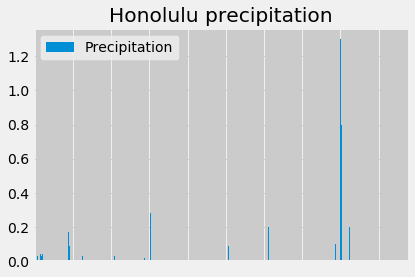

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
honolulu_query_df_sorted.fillna(0, inplace=True)
honolulu_query_df_sorted.plot(kind='bar', title="Honolulu precipitation")

# remove the xtick labels
plt.tick_params(labelbottom=False)
plt.show()

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
honolulu_query_df_sorted.describe()

,Precipitation
count,366.000000
mean,0.021530
std,0.110522
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.300000


In [22]:
# Design a query to show how many stations are available in this dataset?
honolulu_station_count = session.query(Station).group_by(Station.name).count()
print(f"The number of reporting stations is {honolulu_station_count}")

The number of reporting stations is 9


In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
honolulu_station_activity = session.query(Measurement.station, func.count(Measurement.prcp)).\
    group_by(Measurement.station).all()

honolulu_station_activity_df = pd.DataFrame(honolulu_station_activity, columns=['Station', 'Reporting count'])

honolulu_station_activity_df_sort = \
    honolulu_station_activity_df.sort_values(by=['Reporting count'], ascending=False)
honolulu_station_activity_df_sort

,Station,Reporting count
6,USC00519281,2772
1,USC00513117,2696
7,USC00519397,2685
8,USC00519523,2572
3,USC00516128,2484
2,USC00514830,1937
0,USC00511918,1932
4,USC00517948,683
5,USC00518838,342


In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# the most active station is USC00519281.
# assume the temperature is given by the column, tobs
active_station_lowest_temp = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date).first()
active_station_lowest_temp

(70.0)

In [25]:
# highest temperature recorded for the most active station, USC0051928
active_station_highest_temp = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date.desc()).first()
active_station_highest_temp

(79.0)

In [26]:
# average temperature of the most active station, USC0051928
active_station_avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
active_station_avg_temp

[(71.66378066378067)]

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# ascertain the station's name
active_station_name = session.query(Station.name).\
    filter(Station.station == 'USC00519281').first()
print(f"{active_station_name} is the most active station")

('WAIHEE 837.5, HI US',) is the most active station


In [28]:
# Calculate the date 1 year ago from the last data point in the database for Waihee recordings
waihee_date_latest = session.query(Measurement.date).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date.desc()).first()
waihee_date_latest_str = ''.join(waihee_date_latest)         # to convert the tuple to a string
waihee_date_latest_datetime_object = dt.datetime.strptime(waihee_date_latest_str, '%Y-%m-%d')
waihee_date_year_ago = waihee_date_latest_datetime_object - dt.timedelta(days=365)

# convert datetime object to string
waihee_date_year_ago_str = dt.datetime.strftime(waihee_date_year_ago, '%Y-%m-%d')
print(f"Last date for Waihee is {waihee_date_latest_str} "
       + f"and one year earlier is {waihee_date_year_ago_str}")

Last date for Waihee is 2017-08-18 and one year earlier is 2016-08-18


In [29]:
# Perform a query to retrieve the temperature data for the Waihee station for the last 12 months of data
waihee_query = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= waihee_date_year_ago_str).all()
# waihee_query is a list of tuples, which consist of a date string and a tobs float 

In [30]:
# Save the query results as a Pandas DataFrame and set the index to the date column
waihee_query_df = pd.DataFrame(waihee_query, columns=['Date', 'tobs'])
waihee_query_df.set_index('Date', inplace=True)
waihee_query_df.head()

,tobs
Date,
2016-08-18,80.0
2016-08-19,79.0
2016-08-20,81.0
2016-08-21,79.0
2016-08-22,78.0


In [31]:
# Sort the dataframe by date
waihee_query_df_sorted = waihee_query_df.sort_values(by=['Date'])   # default is ascending order
waihee_query_df_sorted.to_csv("temp.csv")
# NOTE: This is unnecessary for a histogram, and we certainly don't want to introduce missing dates, which 
# would have a zero (meaningless) temperature

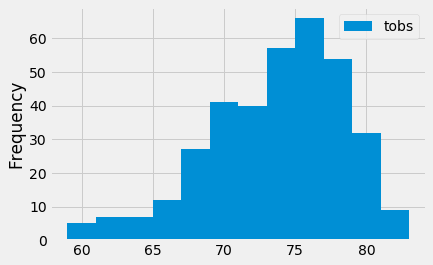

In [32]:
waihee_query_df_sorted.plot.hist(bins=12)   # 12 bins were chosen to match the histogram shown in the example

# Note:  Inspecting the data shows there are no invalid (zero) temperatures, which would skew the histogram

In [33]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


### Note:  The calc_temp function works on the temperature data for **all** of the Hawaiian locations in the dataset 

In [34]:
# Calculate the date 1 year ago from the last data point in the database for all locations recordings
all_date_latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
all_date_latest_str = ''.join(all_date_latest)         # to convert the tuple to a string
all_date_latest_datetime_object = dt.datetime.strptime(all_date_latest_str, '%Y-%m-%d')
all_date_year_ago = all_date_latest_datetime_object - dt.timedelta(days=365)

# convert datetime object to string
all_date_year_ago_str = dt.datetime.strftime(all_date_year_ago, '%Y-%m-%d')
print(f"Last date for all locations is {all_date_latest_str} "
       + f"and one year earlier is {all_date_year_ago_str}")

Last date for all locations is 2017-08-23 and one year earlier is 2016-08-23


In [35]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# print(calc_temps(all_date_year_ago, all_date_latest_str))
temp_stats = calc_temps(all_date_year_ago, all_date_latest_str)
print(temp_stats)

[(58.0, 74.57894736842105, 87.0)]


In [36]:
# values for the next bar chart
tmin = temp_stats[0][0]
tavg = temp_stats[0][1]
tmax = temp_stats[0][2]
tpp = tmax - tmin

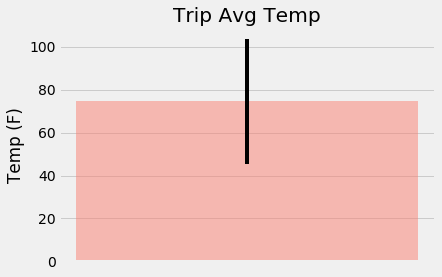

In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
p1 = ax.bar(np.arange(1), tavg, width=1, bottom=0, yerr=tpp, color='salmon', alpha=.5)
ax.set_title('Trip Avg Temp')
ax.grid(axis="x")
ax.set_xticklabels((''))

ax.set_ylabel("Temp (F)")
ax.autoscale_view()

plt.show()

In [38]:
# Calculate the total amount of rainfall per weather station for your trip dates using 
# the previous year's matching dates. Sort this in descending order by precipitation amount
# and list the station, name, latitude, longitude, and elevation

From the README.md: "Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total."

The last date for honolulu data is 2015-10-30, so the vacation dates must be earlier than 2016-10-30 (to use previous year's matching data). Inspecting the honolulu prcp data shows the wettest period is in the last half of February.  So pick vacation to run from 2016-02-14 to 2016-02-28.

To rephrase, create a list of tuples, where each tuple is the station ID for Honolulu, the station name, latitude, longitude, elevation, and precipitation (prcp) for dates 2/14/15 - 2/28/15. 


In [39]:
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, 
       Measurement.station, Measurement.prcp]
vacation_prcp = session.query(*sel).filter(Station.station == Measurement.station).\
    filter(Measurement.date >= '2015-02-14').filter(Measurement.date <= '2015-02-28').all()
vacation_prcp

[('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  'USC00519397',
  0.08),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  'USC00519397',
  0.46),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  'USC00519397',
  0.0),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  'USC00519397',
  0.0),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  'USC00519397',
  0.0),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  'USC00519397',
  0.01),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  'USC00519397',
  0.01),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  'USC00519397',
  0.24),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  'USC00519397',
  0.0),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  'USC00519397',
  0.0),
 ('US

Station
============
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT

Measurement
===========
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

## Optional Challenge Assignment

In [40]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [41]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [42]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
